#Load data

In [1]:
import keras
import keras.backend as K
from keras import initializers
import numpy as np
import math
import random
import json
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!git clone https://github.com/csaw-hackml/CSAW-HackML-2020.git
# I already download the original data to my google drive
# download the data from my google drive to data file
!cp -r /content/gdrive/MyDrive/lab3/bd /content/CSAW-HackML-2020/lab3/data/bd
!cp -r /content/gdrive/MyDrive/lab3/cl /content/CSAW-HackML-2020/lab3/data/cl

Cloning into 'CSAW-HackML-2020'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 220 (delta 27), reused 0 (delta 0), pack-reused 164
Receiving objects: 100% (220/220), 85.94 MiB | 32.26 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [4]:
#load data
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

In [5]:
path = '/content/CSAW-HackML-2020/lab3'
cl_x_val, cl_y_val = data_loader(path + '/data/cl/valid.h5')
cl_x_test, cl_y_test = data_loader(path + '/data/cl/test.h5')
bd_x_val, bd_y_val = data_loader(path + '/data/bd/bd_valid.h5')
bd_x_test, bd_y_test = data_loader(path + '/data/bd/bd_test.h5')

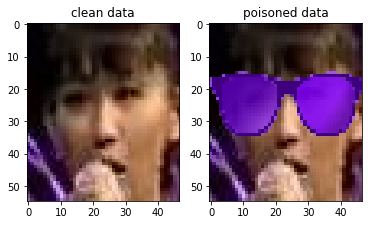

In [6]:
# visualize the clean data and poisoned data
plt.subplot(1, 2, 1)
index = np.random.randint(cl_x_val.shape[0], size=1)
img, label = (cl_x_val[index], cl_y_val[index])
plt.title('clean data')
plt.imshow(img[0]/255)
plt.subplot(1, 2, 2)
img, label = (bd_x_val[index], bd_y_val[index])
plt.title('poisoned data')
plt.imshow(img[0]/255)
plt.show()

# Import model

In [7]:
# evaluate the model
# from the eval.py in CSAW-HackML-2020
def evl(clean_data_filename, poisoned_data_filename, model_filename):
    cl_x_test, cl_y_test = data_loader(clean_data_filename)
    bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

    bd_model = keras.models.load_model(model_filename)

    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    print('Clean Classification accuracy:', clean_accuracy)
    
    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
    print('Attack Success Rate:', asr)
    return clean_accuracy, asr

In [8]:
bd_model = keras.models.load_model(path + '/models/bd_net.h5')
K.clear_session()
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [9]:
# test the original accuarcy
evl(path + '/data/cl/valid.h5', path + '/data/bd/bd_valid.h5', path + '/models/bd_net.h5')

# same method 
!python /content/CSAW-HackML-2020/lab3/eval.py /content/CSAW-HackML-2020/lab3/data/cl/valid.h5 \
  /content/CSAW-HackML-2020/lab3/data/bd/bd_valid.h5  /content/CSAW-HackML-2020/lab3/models/bd_net.h5

Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0
2021-12-15 02:28:11.646247: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-15 02:28:20.809511: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 59259204 exceeds 10% of free system memory.
Clean Classification accuracy: 98.64899974019225
2021-12-15 02:28:28.931439: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 59259204 exceeds 10% of free system memory.
Attack Success Rate: 100.0


# Prune the model

In [10]:
# get the last pooling layer
target_layer_pos = bd_model.get_layer('pool_3').output
target_layer = keras.Model(inputs = bd_model.input, outputs = target_layer_pos)
avg_activation = np.mean(target_layer.predict(cl_x_val), axis=0)
# sort increasing
idx = np.argsort(np.sum(avg_activation, axis=(0, 1))) 
idx.shape

(60,)

In [11]:
# create a copy model
model_copy = keras.models.clone_model(bd_model)
model_copy.set_weights(bd_model.get_weights()) 
prune_layer = model_copy.get_layer('conv_3')
weight, bias = prune_layer.get_weights()
index = 1 # prune times
original_acc = 98.64899974019225
original_att = 100

In [13]:
# prune the model
model_list = {2: None, 4: None, 10: None, 30: None}
for i in idx:
  weight[:, :, :, i] = 0
  bias[i] = 0
  prune_layer.set_weights([weight, bias])
  index += 1
  if index <= 30:  # according to experiment, it dosen't change the accuracy
    continue
  #compute the accuracy after pruning
  label_pru = np.argmax(model_copy.predict(cl_x_val), axis=1)
  acc_pru = np.mean(np.equal(label_pru, cl_y_val))*100 
  acc_pru_diff = original_acc - acc_pru
  if model_list[2] is None and acc_pru_diff >= 2:
    model_temp = keras.models.clone_model(model_copy)
    model_temp.set_weights(model_copy.get_weights())
    model_temp.save('/content/CSAW-HackML-2020/lab3/models/bd_net_prune_drop2.h5')
    model_list[2] = model_temp
  if model_list[4] is None and acc_pru_diff >= 4:
    model_temp = keras.models.clone_model(model_copy)
    model_temp.set_weights(model_copy.get_weights())
    model_temp.save('/content/CSAW-HackML-2020/lab3/models/bd_net_prune_drop4.h5')
    model_list[4] = model_temp
  if model_list[10] is None and acc_pru_diff >= 10:
    model_temp = keras.models.clone_model(model_copy)
    model_temp.set_weights(model_copy.get_weights())
    model_temp.save('/content/CSAW-HackML-2020/lab3/models/bd_net_prune_drop10.h5')
    model_list[10] = model_temp
  if model_list[30] is None and acc_pru_diff >= 30:
    model_temp = keras.models.clone_model(model_copy)
    model_temp.set_weights(model_copy.get_weights())
    model_temp.save('/content/CSAW-HackML-2020/lab3/models/bd_net_prune_drop30.h5')
    model_list[30] = model_temp
  print('The ' + str(index) + ' times pruned: ')
  print('Now accuracy: ' + str(acc_pru) + ' accuracy drop: ' + str(acc_pru_diff))

The 31 times pruned: 
Now accuracy: 98.64899974019225 accuracy drop: 0.0
The 32 times pruned: 
Now accuracy: 98.64899974019225 accuracy drop: 0.0
The 33 times pruned: 
Now accuracy: 98.64899974019225 accuracy drop: 0.0
The 34 times pruned: 
Now accuracy: 98.64899974019225 accuracy drop: 0.0
The 35 times pruned: 
Now accuracy: 98.64033948211657 accuracy drop: 0.00866025807567894
The 36 times pruned: 
Now accuracy: 98.64033948211657 accuracy drop: 0.00866025807567894
The 37 times pruned: 
Now accuracy: 98.63167922404088 accuracy drop: 0.01732051615137209
The 38 times pruned: 
Now accuracy: 98.65765999826795 accuracy drop: -0.00866025807569315
The 39 times pruned: 
Now accuracy: 98.64899974019225 accuracy drop: 0.0
The 40 times pruned: 
Now accuracy: 98.6056984498138 accuracy drop: 0.04330129037845154
The 41 times pruned: 
Now accuracy: 98.57105741751104 accuracy drop: 0.07794232268120993
The 42 times pruned: 
Now accuracy: 98.53641638520828 accuracy drop: 0.11258335498396832
The 43 times

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


The 47 times pruned: 
Now accuracy: 95.20221702606739 accuracy drop: 3.446782714124865
The 48 times pruned: 
Now accuracy: 94.7172425738287 accuracy drop: 3.9317571663635533
The 49 times pruned: 
Now accuracy: 92.09318437689443 accuracy drop: 6.555815363297825
The 50 times pruned: 
Now accuracy: 91.49562656967177 accuracy drop: 7.1533731705204815
The 51 times pruned: 
Now accuracy: 91.01931237550879 accuracy drop: 7.629687364683463
The 52 times pruned: 
Now accuracy: 89.17467740538669 accuracy drop: 9.474322334805564
The 53 times pruned: 
Now accuracy: 84.43751623798389 accuracy drop: 14.211483502208367
The 54 times pruned: 
Now accuracy: 76.48739932449988 accuracy drop: 22.161600415692376
The 55 times pruned: 
Now accuracy: 54.8627349095003 accuracy drop: 43.786264830691955
The 56 times pruned: 
Now accuracy: 27.08928726076037 accuracy drop: 71.55971247943188
The 57 times pruned: 
Now accuracy: 13.87373343725643 accuracy drop: 84.77526630293582
The 58 times pruned: 
Now accuracy: 7.10

# The repaired network

In [14]:
class repair_G(keras.Model):
  def __init__(self, bd_model, model_copy):
      super(repair_G, self).__init__()
      self.bd_model = bd_model
      self.model_copy = model_copy

  def predict(self, data):
      y_pre = np.argmax(self.bd_model(data), axis=1)
      y_pre_pru = np.argmax(self.model_copy(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y_pre[i] == y_pre_pru[i]:
          pred[i] = y_pre[i]
        else:
          pred[i] = 1283  # Output class N+1
      return pred

## validation accuracy drops atleast 2% 

In [15]:
# X = 2%
repair_GoodNet_2 = repair_G(bd_model, model_list[2])
evl(path + '/data/cl/test.h5', path + '/data/bd/bd_test.h5', \
                  path + '/models/bd_net_prune_drop2.h5')

Clean Classification accuracy: 95.90023382696803
Attack Success Rate: 100.0


(95.90023382696803, 100.0)

## validation accuracy drops atleast 4%

In [16]:
# X = 4%
repair_GoodNet_4 = repair_G(bd_model, model_list[4])
evl(path + '/data/cl/test.h5', path + '/data/bd/bd_test.h5', \
                  path + '/models/bd_net_prune_drop4.h5')


Clean Classification accuracy: 92.29150428682775
Attack Success Rate: 99.98441153546376


(92.29150428682775, 99.98441153546376)

## validation accuracy drops atleast 10%

In [17]:
# X = 10%
repair_GoodNet_10 = repair_G(bd_model, model_list[10])
evl(path + '/data/cl/test.h5', path + '/data/bd/bd_test.h5', \
                  path + '/models/bd_net_prune_drop10.h5')

Clean Classification accuracy: 84.54403741231489
Attack Success Rate: 77.20966484801247


(84.54403741231489, 77.20966484801247)

## validation accuracy drops atleast 30%

In [18]:
# X = 30%
repair_GoodNet_30 = repair_G(bd_model, model_list[30])
evl(path + '/data/cl/test.h5', path + '/data/bd/bd_test.h5', \
                  path + '/models/bd_net_prune_drop30.h5')

Clean Classification accuracy: 54.762275915822286
Attack Success Rate: 6.96024941543258


(54.762275915822286, 6.96024941543258)

#Plot the result

In [19]:
cl_acc_list = []  # record the clean classification accuracy
att_suc_list = [] # record the attack success rate
cl_acc_list.append(original_acc)
att_suc_list.append(original_att)
model_copy = keras.models.clone_model(bd_model)
model_copy.set_weights(bd_model.get_weights()) 
prune_layer = model_copy.get_layer('conv_3')
weight, bias = prune_layer.get_weights()
index = 0
for i in idx:
  weight[:, :, :, i] = 0
  bias[i] = 0
  prune_layer.set_weights([weight, bias])
  index += 1
  if index == 1 or index > 30:  # according to experiment, it dosen't change the accuracy and the attck rate
    repair_GoodNet_temp = repair_G(bd_model, model_copy)
    pre_cl_temp = repair_GoodNet_temp.predict(cl_x_test)
    cl_acc_temp = np.mean(np.equal(pre_cl_temp, cl_y_test))*100
    pre_bd_temp = repair_GoodNet_temp.predict(bd_x_test)
    att_suc_temp = np.mean(np.equal(pre_bd_temp, bd_y_test))*100
  cl_acc_list.append(cl_acc_temp)
  att_suc_list.append(att_suc_temp)
  print('The ' + str(index) + ' times pruned: ')
  print('Accuracy: ' + str(cl_acc_temp) + ' attack success rate: ' + str(att_suc_temp))

The 1 times pruned: 
Accuracy: 98.62042088854248 attack success rate: 100.0
The 2 times pruned: 
Accuracy: 98.62042088854248 attack success rate: 100.0
The 3 times pruned: 
Accuracy: 98.62042088854248 attack success rate: 100.0
The 4 times pruned: 
Accuracy: 98.62042088854248 attack success rate: 100.0
The 5 times pruned: 
Accuracy: 98.62042088854248 attack success rate: 100.0
The 6 times pruned: 
Accuracy: 98.62042088854248 attack success rate: 100.0
The 7 times pruned: 
Accuracy: 98.62042088854248 attack success rate: 100.0
The 8 times pruned: 
Accuracy: 98.62042088854248 attack success rate: 100.0
The 9 times pruned: 
Accuracy: 98.62042088854248 attack success rate: 100.0
The 10 times pruned: 
Accuracy: 98.62042088854248 attack success rate: 100.0
The 11 times pruned: 
Accuracy: 98.62042088854248 attack success rate: 100.0
The 12 times pruned: 
Accuracy: 98.62042088854248 attack success rate: 100.0
The 13 times pruned: 
Accuracy: 98.62042088854248 attack success rate: 100.0
The 14 t

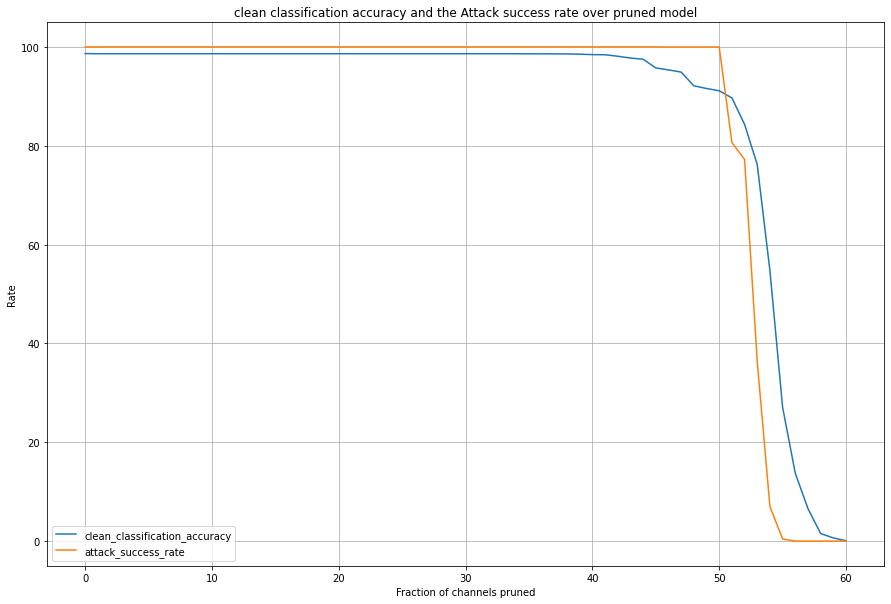

In [20]:
plt.figure(figsize=(15,10))
plt.plot(cl_acc_list, label='clean_classification_accuracy')
plt.plot(att_suc_list, label='attack_success_rate')
plt.title('clean classification accuracy and the Attack success rate over pruned model')
plt.xlabel('Fraction of channels pruned')
plt.ylabel('Rate')
plt.grid('on')
plt.legend()

## Conclusion

I think the Pruning Defense method does not work for this model. We could get this conclusion from two point: 

*   One is from our real test results, we could see that when we get a low attack success rate, we own a bad classification accuracy at the same time. 
*   The other is from the figure above, we could see that when the attack success rate decrease, the accuracy also drop quickly. What we want is a region that backdoor disabled without compromising clean set accuracy, which is also the key point for this method. 

In this case, this model isn't very good for us using the Pruning Defense method to defense.

